In [6]:
"""
A simple test to check if the RFAE model loads and runs properly
on toy datasets, producing train/test embeddings.
"""

from rfae import RFAE
from sklearn.datasets import load_digits, load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


# Load some dataset

In [7]:
data_name = "digits"  # Change to "diabetes" to test on diabetes dataset



if data_name == "digits":
    data = load_digits()
elif data_name == "breast_cancer":
    data = load_breast_cancer()
elif data_name == "wine":
    data = load_wine()


x = data.data
y = data.target

print(f"Dataset: {data_name}, Samples: {len(x)}, Features: {x.shape[1]}")

Dataset: digits, Samples: 1797, Features: 64



# Split into train/test sets


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize and fit RFAE


In [9]:
model = RFAE(
    n_components=2,
    epochs=100,
    lam=0.01,
    pct_prototypes=0.2,
    random_state=4,
    embedder_params={'verbose': False, 'n_estimators': 500, 'prox_method': 'rfgap',
                     'self_similarity': False}
)

emb_train = model.fit_transform(x_train, y_train)
emb_test = model.transform(x_test)

print("Embedding shapes:", emb_train.shape, emb_test.shape)

2025-11-03 16:54:53,622 - INFO - Epoch 0/100 - Recon Loss: 0.4931416 - Geo Loss: 0.0038785
2025-11-03 16:54:54,411 - INFO - Epoch 50/100 - Recon Loss: 0.2150762 - Geo Loss: 0.0001003
Embedding shapes: (1437, 2) (360, 2)


# Visualization

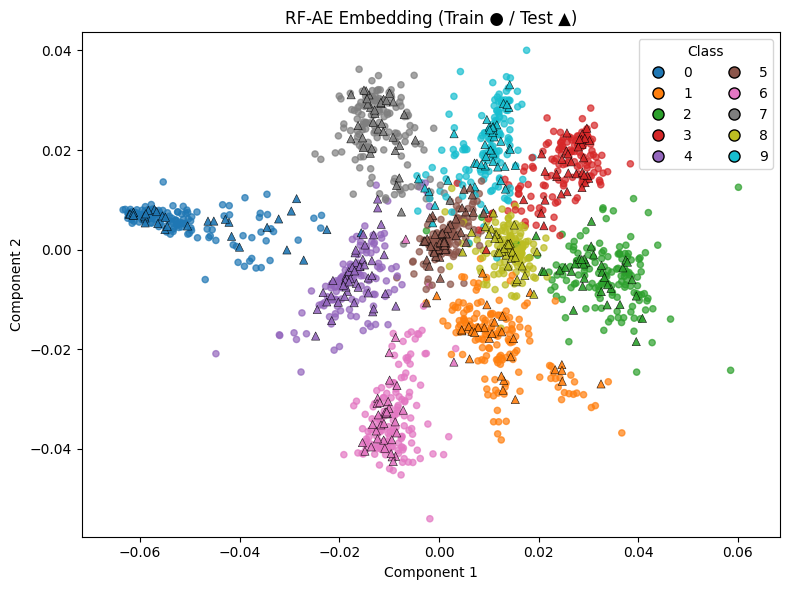

In [10]:
plt.figure(figsize=(8, 6))

# Plot training (circles) and test (triangles)
train_scatter = plt.scatter(
    emb_train[:, 0], emb_train[:, 1],
    c=y_train, cmap='tab10',
    s=20, alpha=0.7, marker='o'
)
test_scatter = plt.scatter(
    emb_test[:, 0], emb_test[:, 1],
    c=y_test, cmap='tab10',
    s=35, alpha=0.9, marker='^',
    edgecolors='k', linewidths=0.4
)

plt.title("RF-AE Embedding (Train ● / Test ▲)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.axis("equal")

# ---------------------------------------------------------
# Create dot-based legend: one dot per class (color-coded)
# ---------------------------------------------------------
classes = np.unique(np.concatenate([y_train, y_test]))
cmap = plt.get_cmap('tab10')
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='none',
        markerfacecolor=cmap(i % 10),
        markersize=8,
        label=str(cls)
    )
    for i, cls in enumerate(classes)
]

plt.legend(
    handles=handles,
    title="Class",
    loc='best',
    frameon=True,
    ncol=2
)

plt.tight_layout()
plt.show()